## Import libraries

In [1]:
#!pip install pandas==2.2.1
#!pip install ydata-profiling==4.7.0
#!pip install ipywidgets==8.1.2
#!pip install scikit-learn==1.4.1.post1
#!pip install setuptools==69.2.0
#!pip install tensorflow==2.16.1
#!pip install -U imbalanced-learn==0.12.2
#!pip install seaborn==0.13.2

In [2]:
import pandas as pd
from ydata_profiling import ProfileReport
# Minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# Train test split
from sklearn.model_selection import train_test_split
# Resampling minority class
from sklearn.utils import resample
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
# Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Class weights
from sklearn.utils import class_weight
import numpy as np
# Tensorboard
import datetime
from tensorflow.keras.callbacks import TensorBoard
# Confusion matrix
from sklearn.metrics import confusion_matrix
# Undersampling and oversampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# SHAP
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance


%matplotlib inline
%load_ext tensorboard

## Store CSV as a DF

In [3]:
# Read the data from heart_attack.csv making the first row the header
data = pd.read_csv('heart_attack.csv', header=0, sep=';')

# Display the first 5 rows of the data
print(data.head())

      id  gender   age  hypertension  coronary_heart_disease married  \
0   9046    Male  67.0             0                       1     Yes   
1  51676  Female  61.0             0                       0     Yes   
2  31112    Male  80.0             0                       1     Yes   
3  60182  Female  49.0             0                       0     Yes   
4   1665  Female  79.0             1                       0     Yes   

             job residence  glucose_level   bmi    tobacco_use  heart_attack  
0        Private     Urban         228.69  36.6  Former smoker             1  
1  Self-employed     Rural         202.21   NaN          Never             1  
2        Private     Rural         105.92  32.5          Never             1  
3        Private     Urban         171.23  34.4         Smoker             1  
4  Self-employed     Rural         174.12  24.0          Never             1  


### Clean the data

In [4]:
# Drop the id column

data = data.drop('id', axis=1)
data.head()

,gender,age,hypertension,coronary_heart_disease,married,job,residence,glucose_level,bmi,tobacco_use,heart_attack
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,Former smoker,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,Never,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,Never,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,Smoker,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,Never,1


In [5]:
profile = ProfileReport(data, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Eliminate the rows form bmi that are missing
data = data.dropna(subset=['bmi'])
data.head()

,gender,age,hypertension,coronary_heart_disease,married,job,residence,glucose_level,bmi,tobacco_use,heart_attack
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,Former smoker,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,Never,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,Smoker,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,Never,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,Former smoker,1


## Encoding

In [7]:
data.loc[:, 'gender'] = data['gender'].map({'Male': 0, 'Female': 1})
data.loc[:, 'married'] = data['married'].map({'No': 0, 'Yes': 1})
data.loc[:, 'job'] = data['job'].map({'Unemployed': 0, 'Private': 1, 'Self-employed': 2, 'Government employee': 3, 'Minor': 4})
data.loc[:, 'residence'] = data['residence'].map({'Rural': 0, 'Urban': 1})
data.loc[:, 'tobacco_use'] = data['tobacco_use'].map({'Former smoker': 0, 'Never': 1, 'Smoker': 2, 'Unknown': 3})

In [8]:
data.head()

,gender,age,hypertension,coronary_heart_disease,married,job,residence,glucose_level,bmi,tobacco_use,heart_attack
0,0.0,67.0,0,1,1,1,1,228.69,36.6,0,1
2,0.0,80.0,0,1,1,1,0,105.92,32.5,1,1
3,1.0,49.0,0,0,1,1,1,171.23,34.4,2,1
4,1.0,79.0,1,0,1,2,0,174.12,24.0,1,1
5,0.0,81.0,0,0,1,1,1,186.21,29.0,0,1


In [9]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_normalized.head()

,gender,age,hypertension,coronary_heart_disease,married,job,residence,glucose_level,bmi,tobacco_use,heart_attack
0,0.0,0.816895,0.0,1.0,1.0,0.25,1.0,0.801265,0.301260,0.000000,1.0
1,0.0,0.975586,0.0,1.0,1.0,0.25,0.0,0.234512,0.254296,0.333333,1.0
2,1.0,0.597168,0.0,0.0,1.0,0.25,1.0,0.536008,0.276060,0.666667,1.0
3,1.0,0.963379,1.0,0.0,1.0,0.50,0.0,0.549349,0.156930,0.333333,1.0
4,0.0,0.987793,0.0,0.0,1.0,0.25,1.0,0.605161,0.214204,0.000000,1.0


In [10]:
profile = ProfileReport(data, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correct imbalances

In [11]:
# Drop hypertension and coronary_heart_disease
data_normalized = data_normalized.drop(['hypertension', 'coronary_heart_disease'], axis=1)


## MLP

### Tensorboard Configuration

In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
# Separate labels and features
y = data_normalized['heart_attack']
X = data_normalized.drop('heart_attack', axis=1)  #  'heart_attack' is the value we want to predict

In [14]:
# Since we have an imbalanced dataset, we will distribute the minority class accordingly
# Divide first into training and temporary (test + validation) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Stratify to keep the distribution of classes in the training set
)

# Luego, dividir el conjunto temporal en conjuntos de prueba y validación
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=(2/3),
    random_state=42,
    stratify=y_temp  # Stratify here as well
)

# Define the undersampling method
undersample = RandomUnderSampler(sampling_strategy='majority')

# Apply the undersampling
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Define the oversampling method
smote = SMOTE(sampling_strategy='minority')

# Apply the oversampling
#X_train, y_train = smote.fit_resample(X_train, y_train)

print("Distribution of classes in the training set:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of classes in the validation set:")
print(y_val.value_counts(normalize=True))

print("\nDistribution of classes in the test set:")
print(y_test.value_counts(normalize=True))



Distribution of classes in the training set:
heart_attack
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

Distribution of classes in the validation set:
heart_attack
0.0    0.95723
1.0    0.04277
Name: proportion, dtype: float64

Distribution of classes in the test set:
heart_attack
0.0    0.95723
1.0    0.04277
Name: proportion, dtype: float64


In [15]:
# Reset the index of the dataframes
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [16]:
%tensorboard --logdir logs/fit
# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Use the Input layer to specify the input shape
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dropout(0.2))  # Dropout layer
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
optimizer = SGD(learning_rate=0.001, momentum=0.5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=50, callbacks=[tensorboard_callback])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc*100:.2f}%')

Reusing TensorBoard on port 6007 (pid 22544), started 2:19:44 ago. (Use '!kill 22544' to kill it.)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4946 - loss: 0.6927 - val_accuracy: 0.9511 - val_loss: 0.6682
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4758 - loss: 0.6931 - val_accuracy: 0.9491 - val_loss: 0.6684
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4907 - loss: 0.6923 - val_accuracy: 0.9491 - val_loss: 0.6685
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4953 - loss: 0.6932 - val_accuracy: 0.9491 - val_loss: 0.6687
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4926 - loss: 0.6921 - val_accuracy: 0.9491 - val_loss: 0.6688
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5009 - loss: 0.6918 - val_accuracy: 0.9491 - val_loss: 0.6690
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 0.6911 - val_accuracy: 0.9491 - val_loss: 0.6692
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4902 - loss: 0.6924 - val_accuracy: 0.9491 - val_loss:

In [17]:
# Making predictions to represent the confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


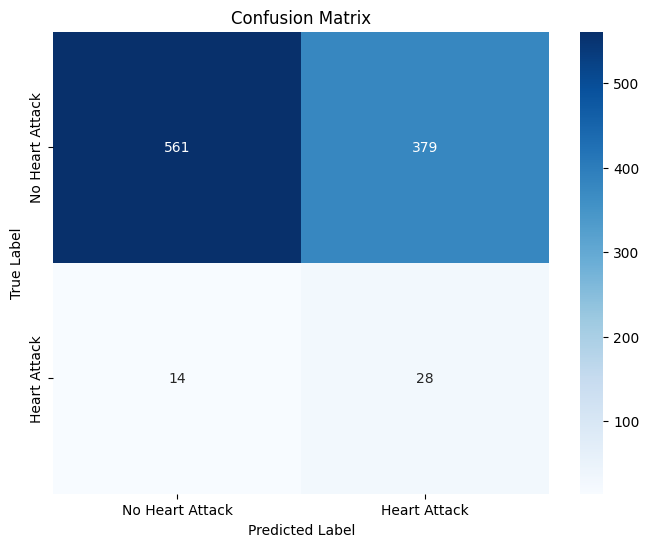

In [18]:
# Labels for the cells
class_names = ['No Heart Attack', 'Heart Attack']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Grid Search

In [19]:
# Combinations of hyperparameters
num_hidden_layers = [0, 1, 2]  # Number of additional hidden layers
learning_rates = [0.001, 0.01, 0.1]  # Learning rates
momentums = [0.0, 0.5, 0.9]  # Number of "momentums"
neurons_per_layer = [16, 32, 64]  # Number of nuerons per hidden layer

# List to store the results
results = []

# Store the best models
best_models = []

for layers in num_hidden_layers:
    for lr in learning_rates:
        for momentum in momentums:
            for neurons in neurons_per_layer:
                # Define the model
                model = Sequential()
                model.add(Input(shape=(X_train.shape[1],)))  # Input layer
                model.add(Dense(neurons, activation='relu'))
                for _ in range(layers - 1):  # Add the hidden layers
                    model.add(Dense(neurons, activation='relu'))
                model.add(Dense(1, activation='sigmoid'))  # Output layer
                
                # Compile the model
                optimizer = SGD(learning_rate=lr, momentum=momentum)
                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                
                # Train the model
                history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=50, verbose=0)

                # Evaluate the model
                test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

                # Verify if the model is one of the n best in order to store it
                if len(best_models) < 5:
                    best_models.append((test_acc, model))
                    best_models.sort(reverse=True, key=lambda x: x[0])  # Order the models in descending order
                elif test_acc > best_models[-1][0]:
                    # Replace the worst model with the new one
                    best_models[-1] = (test_acc, model)
                    best_models.sort(reverse=True, key=lambda x: x[0])  # Reorder the models
                
                # Store the results
                results.append({'layers': layers + 1, 'learning_rate': lr, 'momentum': momentum, 'neurons': neurons, 'test_acc': test_acc, 'test_loss': test_loss})

# Transform the results to a DataFrame
results_df = pd.DataFrame(results)

In [20]:
pd.set_option('display.max_rows', None)
print(results_df.sort_values(by='test_acc', ascending=False))

    layers  learning_rate  momentum  neurons  test_acc  test_loss
0        1          0.001       0.0       16  0.956212   0.575007
1        1          0.001       0.0       32  0.956212   0.573333
55       3          0.001       0.0       32  0.940937   0.610748
24       1          0.100       0.9       16  0.837067   0.340000
25       1          0.100       0.9       32  0.801426   0.403902
74       3          0.100       0.0       64  0.774949   0.442736
53       2          0.100       0.9       64  0.764766   0.451441
26       1          0.100       0.9       64  0.757638   0.446167
50       2          0.100       0.5       64  0.748473   0.494036
76       3          0.100       0.5       32  0.744399   0.480214
48       2          0.100       0.5       16  0.729124   0.508996
71       3          0.010       0.9       64  0.728106   0.489987
75       3          0.100       0.5       16  0.723014   0.479417
79       3          0.100       0.9       32  0.707739   0.515889
23       1

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


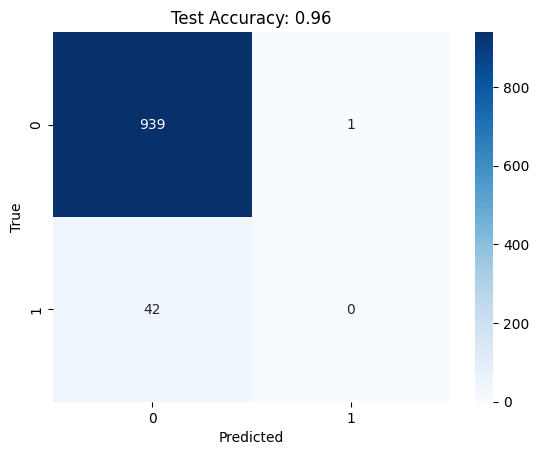

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


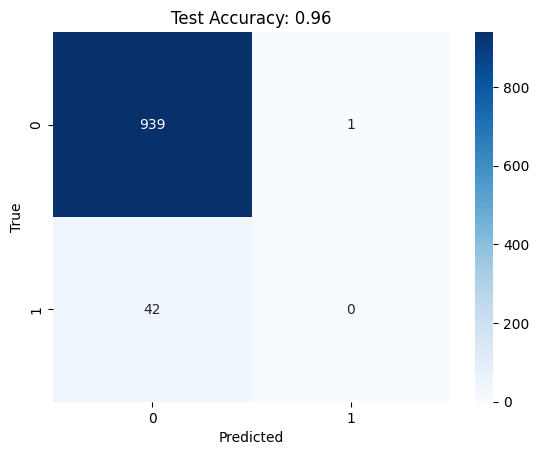

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


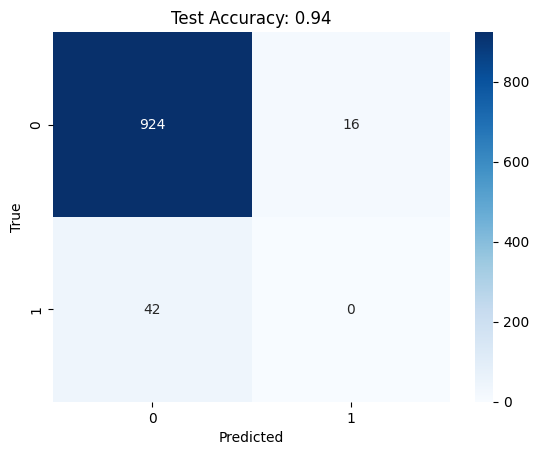

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


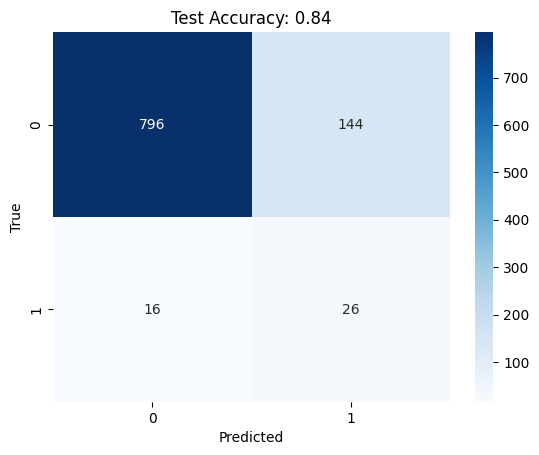

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


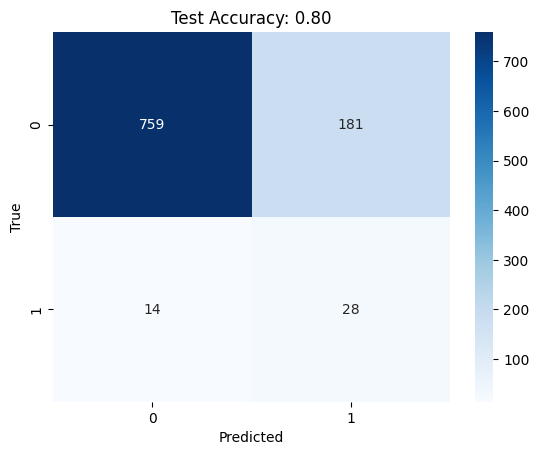

In [21]:
for test_acc, model in best_models:
    y_pred_prob = model.predict(X_test)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Test Accuracy: {test_acc:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

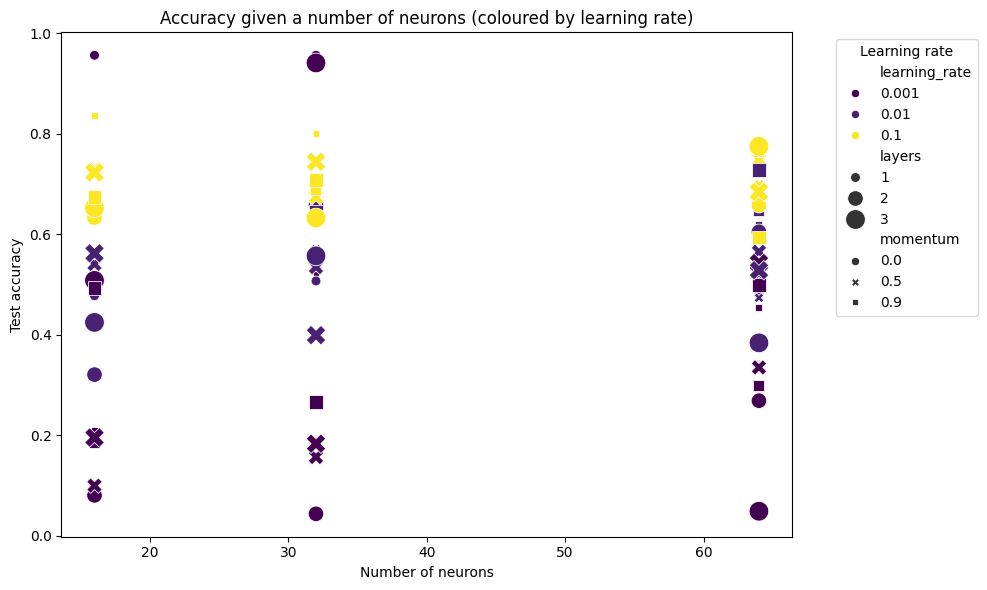

In [22]:
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(data=results_df, x='neurons', y='test_acc', hue='learning_rate', style='momentum', size='layers', palette='viridis', sizes=(50, 200))
plt.title('Accuracy given a number of neurons (coloured by learning rate)')
plt.xlabel('Number of neurons')
plt.ylabel('Test accuracy')
plt.legend(title='Learning rate', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Improve the display of the plot
plt.show()


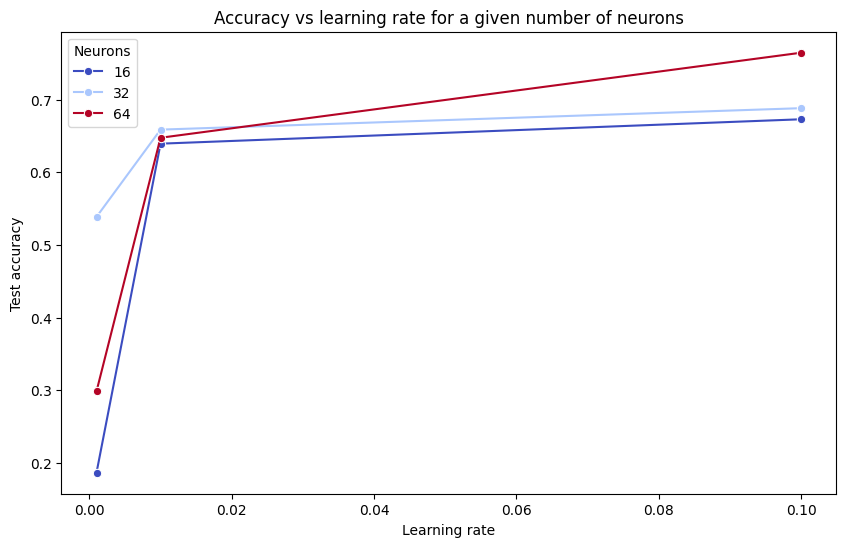

In [23]:
# Filter the results to show only the models with 2 hidden layers and momentum of 0.9
filtered_df = results_df[results_df['layers'] == 2]
filtered_df = filtered_df[filtered_df['momentum'] == 0.9]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='learning_rate', y='test_acc', hue='neurons', marker='o', palette='coolwarm')
plt.title('Accuracy vs learning rate for a given number of neurons')
plt.xlabel('Learning rate')
plt.ylabel('Test accuracy')
plt.legend(title='Neurons')
plt.show()


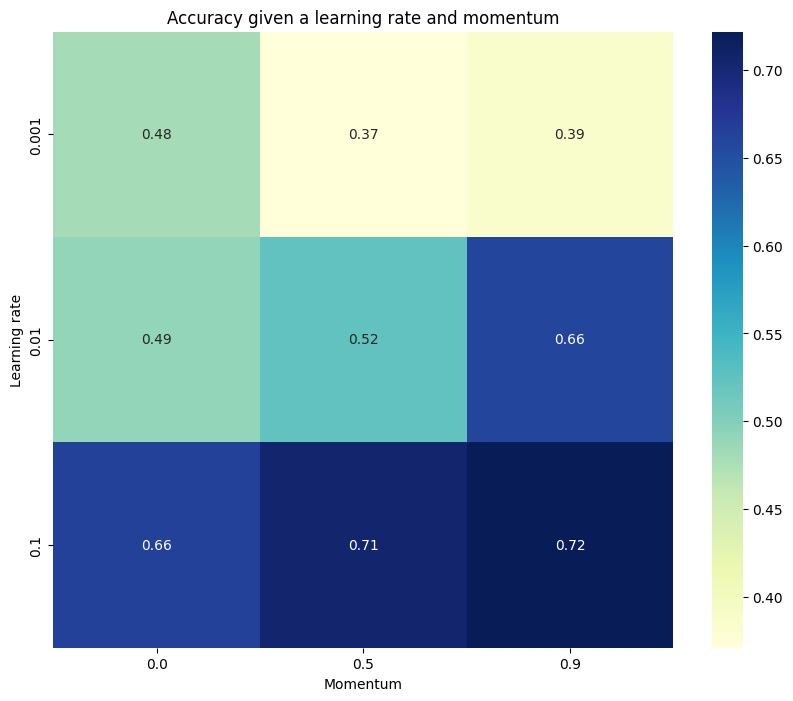

In [24]:
heatmap_data = results_df.pivot_table(index="learning_rate", columns="momentum", values="test_acc", aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Accuracy given a learning rate and momentum')
plt.xlabel('Momentum')
plt.ylabel('Learning rate')
plt.show()



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


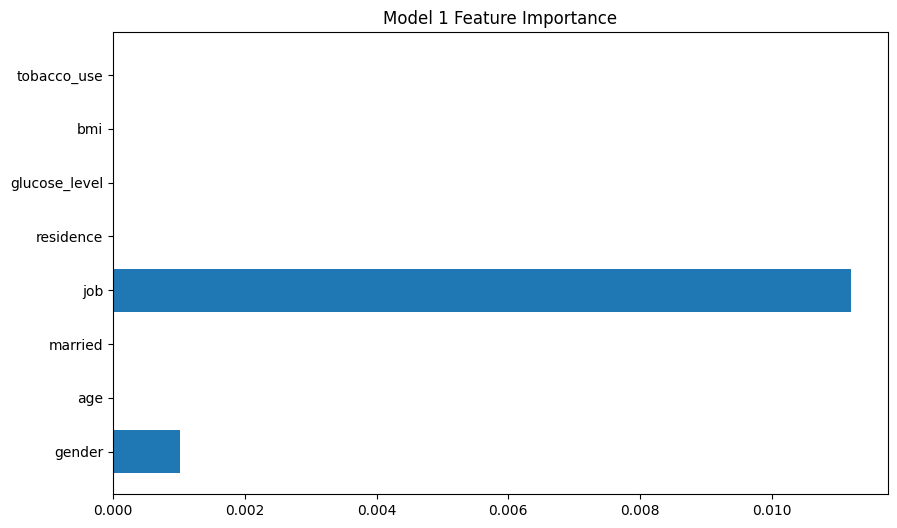

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


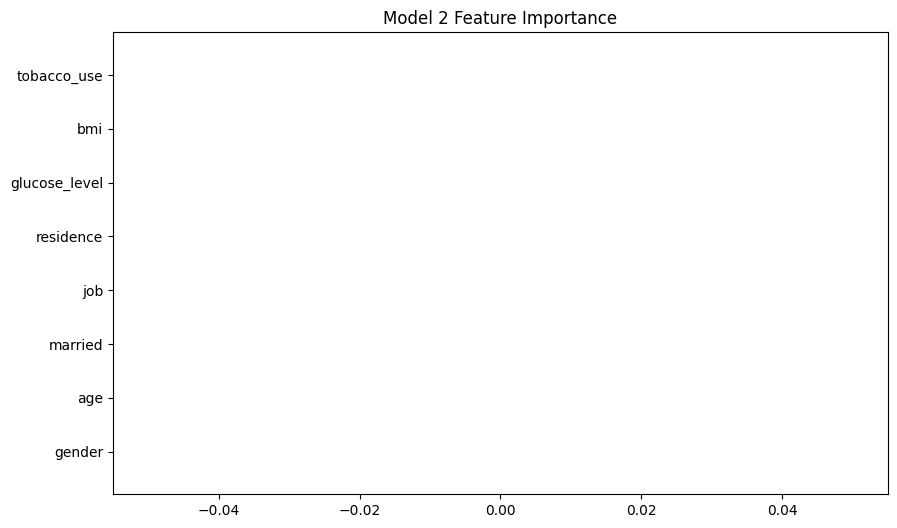

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


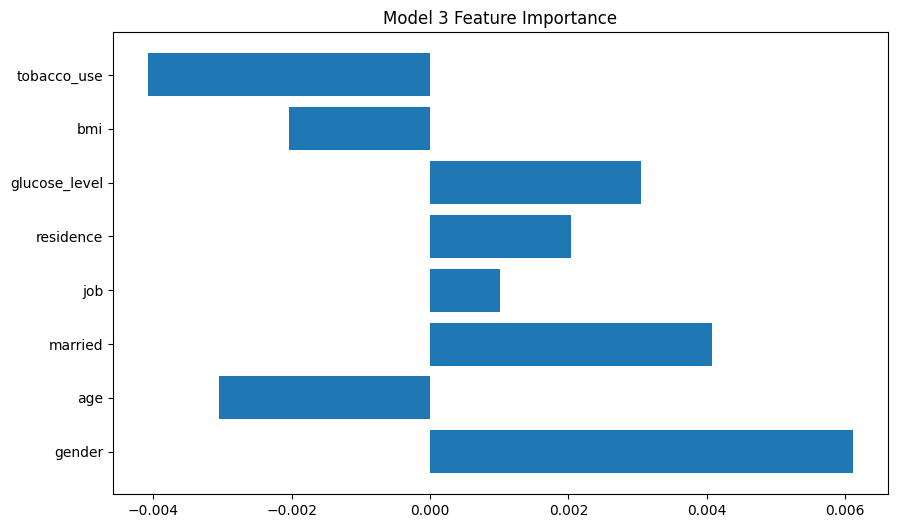

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


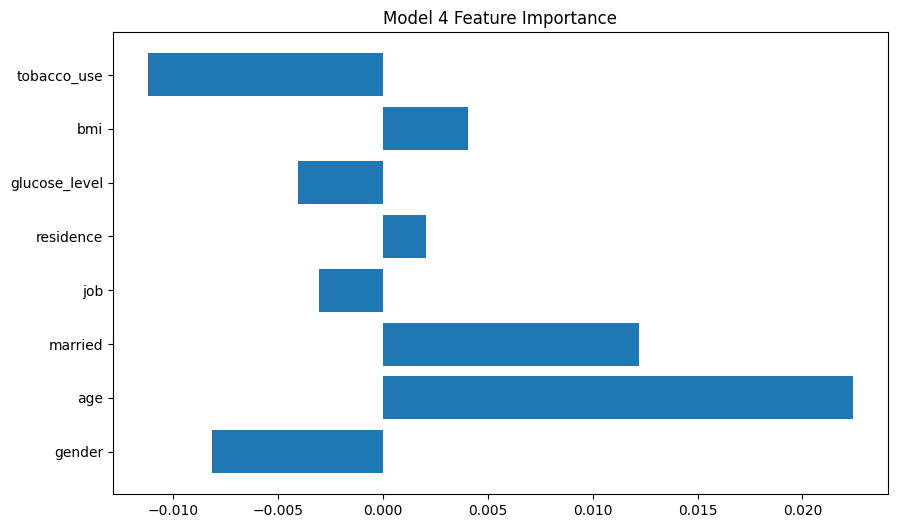

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


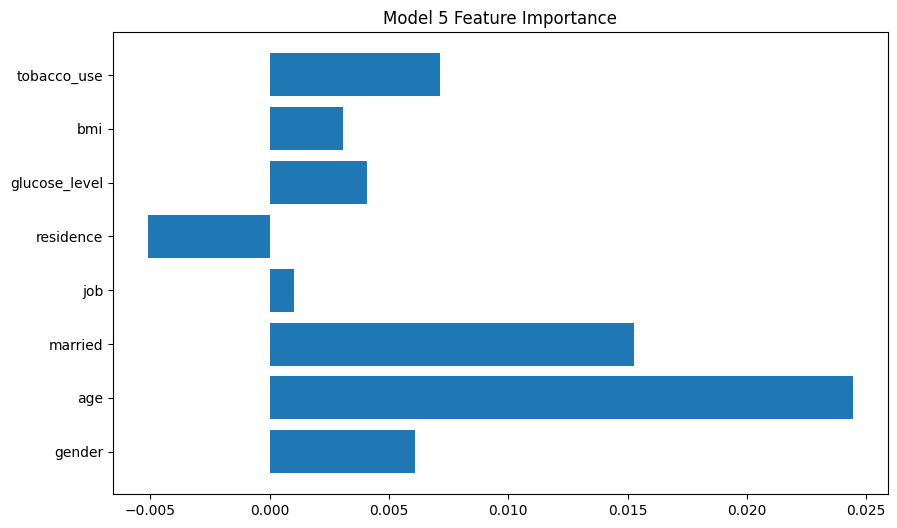

In [25]:

def calculate_feature_importance(model, X_test, y_test):
    # Transform the probabilities to class labels
    original_preds = model.predict(X_test)
    y_pred_original = (original_preds > 0.5).astype(int).flatten()  # Flatten
    original_accuracy = accuracy_score(y_test, y_pred_original)
    
    importances = []
    for i in range(X_test.shape[1]):
        # Permute the feature by converting to NumPy array first to avoid warnings
        X_test_permuted = X_test.copy().to_numpy()  # Transform to NumPy array
        np.random.shuffle(X_test_permuted[:, i])  # Permute the i-th column
        
        # Evaluate the model with the permuted feature
        permuted_preds = model.predict(X_test_permuted)
        y_pred_permuted = (permuted_preds > 0.5).astype(int).flatten()  # Igualmente, aplanar
        permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
        
        # Calculate the importance
        importance = original_accuracy - permuted_accuracy
        importances.append(importance)
    
    return importances

# Calculate the feature importance for the best models
for idx, (test_acc, model) in enumerate(best_models):
    importances = calculate_feature_importance(model, X_test, y_test)
    plt.figure(figsize=(10, 6))
    plt.barh(range(X_test.shape[1]), importances)
    plt.yticks(ticks=range(X_test.shape[1]), labels=X_test.columns)
    plt.title(f'Model {idx+1} Feature Importance')
    plt.show()
